In [1]:
import os

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sgutil, sgml

for i in [pd, np, sns, mpl]:
    print(i.__name__, i.__version__)

pandas 2.2.2
numpy 1.26.4
seaborn 0.13.2
matplotlib 3.8.4


In [2]:
# 주요 파일의 경로를 설정합니다.
data_path = 'data'
files = {
    k: os.path.join(p, f)
    for k, p, f in [
        ('train', data_path, 'train.csv'),
        ('test', data_path, 'test.csv'),
        ('org', data_path, 'data.csv'),
        ('train_pkl', data_path, 'train.pkl'),
        ('org_pkl', data_path, 'org.pkl'),
        ('test_pkl', data_path, 'test.pkl'),
        ('var_pkl', data_path, 'var.pkl')
    ]
}
# fig, result cache 처리기를 생성합니다.
sc = sgutil.SGCache('img', 'result')
# 처리된 데이터를 불러옵니다.
df_train = pd.read_pickle(files['train_pkl'])
df_test = pd.read_pickle(files['test_pkl'])
df_org = pd.read_pickle(files['org_pkl'])
df_var = pd.read_pickle(files['var_pkl'])

# 변수를 유형별로 정리합니다.
target = 'Target'
X_cat = [i for i in df_var.loc[df_var['var_type'] == 'Categorical'].index.tolist() if i != target]
X_bool = [
    'Daytime/evening attendance', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date',
    'Gender', 'Scholarship holder', 'International'
]
X_ord = ['Application order', 'Previous qualification', "Mother's qualification", "Father's qualification"]
X_num = df_var.loc[(~df_var.index.isin(X_cat + X_bool + X_ord + [target]))].index.tolist()
X_all = X_cat + X_bool + X_ord + X_num

## Target

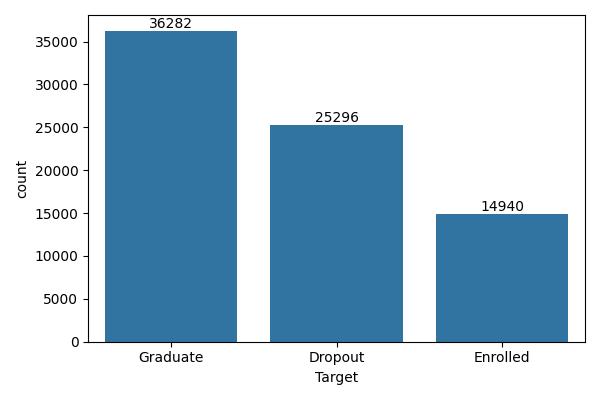

In [3]:
sc.cache_fig(
    'target_count',
    lambda x: [x.bar_label(i) for i in sns.barplot(df_train['Target'].value_counts(), ax=x).containers],
    figsize=(6, 4)
)

## Train과 Test의 차이

In [4]:
df_istrain = pd.concat([
    df_train.assign(is_train=1),
    df_test.assign(is_train=0)
], axis = 0)

In [5]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

def predict_is_train(m, df_valid, X):
    return pd.Series(m.predict_proba(df_valid[X])[:, 1], index=df_valid.index)
def eval_metric_is_train(y_true, prds):
    return roc_auc_score(y_true.sort_index()['is_train'], prds.sort_index())

is_train_result = sc.cache_result(
    'is_train_result',
    lambda : sgml.cv_model(
        StratifiedKFold(n_splits=5, random_state=123, shuffle=True), 
        lgb.LGBMClassifier, {'verbose': -1, 'n_estimators': 500}, df_istrain, X_cat + X_bool + X_ord + X_num, 'is_train',
        result_proc=sgml.lgb_learning_result,
        predict_func=predict_is_train, eval_metric = eval_metric_is_train,
        train_params={
            'valid_splitter': lambda x: train_test_split(x, train_size=0.9, stratify=x['is_train'], random_state=123),
            'fit_params': {'categorical_feature': X_cat, 'callbacks': [lgb.early_stopping(5, verbose=False)]},
            'valid_config_proc': sgml.gb_valid_config
        }
    )
)

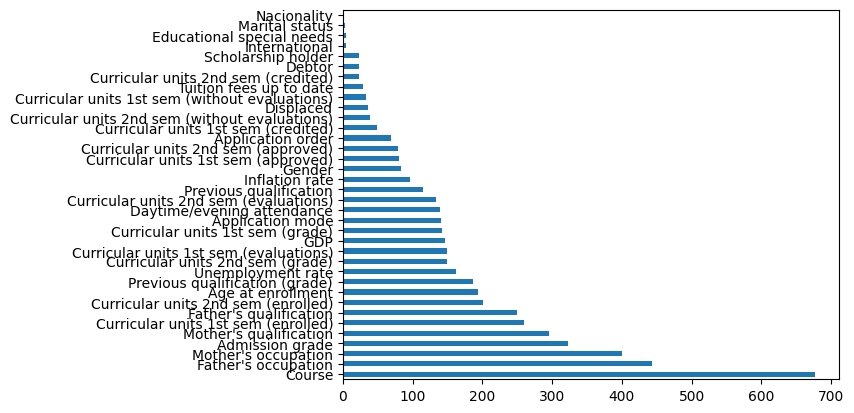

In [6]:
pd.concat([i[1] for i in is_train_result[3]], axis=1).mean(axis=1).sort_values(ascending=False).plot(kind='barh')
plt.show()

In [7]:
np.mean(is_train_result[1])

0.999879455793093

학습/평가 데이터를 분류하는 교차검증을 해본결과 

학습 데이터와 평가 데이터는 차이가 극명히 존재합니다. 살펴봅니다.

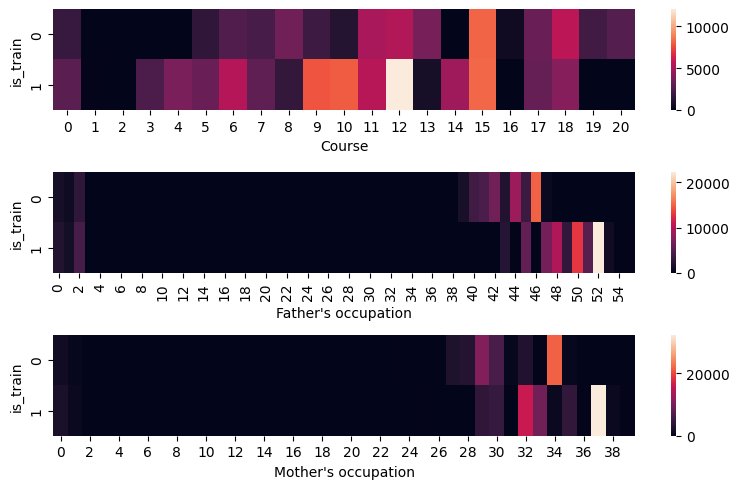

In [8]:
sc.cache_fig(
    'heat_map_cat',
    lambda x: [
        sns.heatmap(
            df_istrain.pivot_table(index='is_train', columns=i, aggfunc='size').fillna(0), ax=ax
        ) for i, ax in zip(['Course', "Father's occupation", "Mother's occupation"], x)
    ], nrow=3, ncol=1, figsize=(8, 5), redraw=True
)
plt.show()

In [9]:
df_var.loc["Course", "Description"].iloc[0]

'33 - Biofuel Production Technologies 171 - Animation and Multimedia Design 8014 - Social Service (evening attendance) 9003 - Agronomy 9070 - Communication Design 9085 - Veterinary Nursing 9119 - Informatics Engineering 9130 - Equinculture 9147 - Management 9238 - Social Service 9254 - Tourism 9500 - Nursing 9556 - Oral Hygiene 9670 - Advertising and Marketing Management 9773 - Journalism and Communication 9853 - Basic Education 9991 - Management (evening attendance)'

In [10]:
df_var.loc["Father's occupation", "Description"].iloc[0]

'0 - Student 1 - Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers 2 - Specialists in Intellectual and Scientific Activities 3 - Intermediate Level Technicians and Professions 4 - Administrative staff 5 - Personal Services, Security and Safety Workers and Sellers 6 - Farmers and Skilled Workers in Agriculture, Fisheries and Forestry 7 - Skilled Workers in Industry, Construction and Craftsmen 8 - Installation and Machine Operators and Assembly Workers 9 - Unskilled Workers 10 - Armed Forces Professions 90 - Other Situation 99 - (blank) 101 - Armed Forces Officers 102 - Armed Forces Sergeants 103 - Other Armed Forces personnel 112 - Directors of administrative and commercial services 114 - Hotel, catering, trade and other services directors 121 - Specialists in the physical sciences, mathematics, engineering and related techniques 122 - Health professionals 123 - teachers 124 - Specialists in finance, accounting, administrative org

In [11]:
df_var.loc["Mother's occupation", "Description"].iloc[0]

'0 - Student 1 - Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers 2 - Specialists in Intellectual and Scientific Activities 3 - Intermediate Level Technicians and Professions 4 - Administrative staff 5 - Personal Services, Security and Safety Workers and Sellers 6 - Farmers and Skilled Workers in Agriculture, Fisheries and Forestry 7 - Skilled Workers in Industry, Construction and Craftsmen 8 - Installation and Machine Operators and Assembly Workers 9 - Unskilled Workers 10 - Armed Forces Professions 90 - Other Situation 99 - (blank) 122 - Health professionals 123 - teachers 125 - Specialists in information and communication technologies (ICT) 131 - Intermediate level science and engineering technicians and professions 132 - Technicians and professionals, of intermediate level of health 134 - Intermediate level technicians from legal, social, sports, cultural and similar services 141 - Office workers, secretaries in general and 

이 변수들은 범주형으로 다루어서는 평가 데이터에 대한 예측 성능을 기대하기 힘들어 보입니다. 범주가 지닌 텍스트를 기반으로 접근을 해볼만합니다.

In [12]:
df_var

,Role,Type,Demographic,Description,type,src,var_type
Marital status,Feature,Integer,Marital status,1 – single 2 – married 3 – widower 4 – divorce...,Categorical,org,Categorical
Application mode,Feature,Integer,NaN,1 - 1st phase - general contingent 2 - Ordinan...,Categorical,org,Categorical
Application order,Feature,Integer,NaN,Application order (between 0 - first choice; a...,Int8,org,Int8
Course,Feature,Integer,NaN,33 - Biofuel Production Technologies 171 - Ani...,Categorical,org,Categorical
Daytime/evening attendance,Feature,Integer,NaN,1 – daytime 0 - evening,Int8,org,Int8
Previous qualification,Feature,Integer,Education Level,1 - Secondary education 2 - Higher education -...,Int8,org,Int8
Previous qualification (grade),Feature,Continuous,NaN,Grade of previous qualification (between 0 and...,Float32,org,Float32
Nacionality,Feature,Integer,Nationality,1 - Portuguese; 2 - German; 6 - Spanish; 11 - ...,Categorical,org,Categorical
Mother's qualification,Feature,Integer,Education Level,1 - Secondary Education - 12th Year of Schooli...,Int8,org,Int8
Father's qualification,Feature,Integer,Education Level,1 - Secondary Education - 12th Year of Schooli...,Int8,org,Int8
